In [1]:
import covasim as cv
import numpy as np
import pandas as pd
from scipy import optimize

cv.options.set('jupyter', verbose=0)
# needs Covasim 3.1.0 fix for gof kwargs

Covasim 3.1.1 (2021-12-06) — © 2021 by IDM


In [2]:
# real german data
pop_size_total = 83780000
number_infected = 30000  # estimation "Dunkelziffer" 2 x https://www.worldometers.info/coronavirus/country/germany/#graph-cases-daily for 09-2020
datafile = 'data_covasim_de_2020.csv'
df = pd.read_csv(datafile)
df.tail()

,Unnamed: 0,date,new_diagnoses,new_deaths,new_tests
345,345,2020-12-10,23679,440,216577
346,346,2020-12-11,29875,598,216577
347,347,2020-12-12,28438,496,216577
348,348,2020-12-13,20200,321,216577
349,349,2020-12-14,16362,188,238862


In [3]:
# simulation data
n_agents = 200000
n_beds_hosp = round(8 * n_agents / 1000)  # https://tradingeconomics.com/germany/hospital-beds - 8 per 1000 people
n_beds_icu = round(620 * n_agents / 100000)  # https://tradingeconomics.com/germany/icu-beds - 620 per 100.000 people
pop_infected = round(n_agents * (number_infected / pop_size_total))

pop_size_sim = 1000000  # scaled simulated people
# scale the original data accordingly with 7 day rolling mean window
for col in ['new_diagnoses', 'new_deaths', 'new_tests']:
    df[col] = df[col] / pop_size_total * pop_size_sim
    df[col] = np.round(df[col].rolling(7).mean())

# select dates
start_day = '2020-09-01'
end_day = '2020-12-14'
df['date'] = pd.to_datetime(df['date'])
mask = (df['date'] >= start_day) & (df['date'] <= end_day)
df = df.loc[mask]
df.tail()

,Unnamed: 0,date,new_diagnoses,new_deaths,new_tests
345,345,2020-12-10,231.0,5.0,2497.0
346,346,2020-12-11,242.0,5.0,2526.0
347,347,2020-12-12,251.0,5.0,2556.0
348,348,2020-12-13,255.0,5.0,2585.0
349,349,2020-12-14,262.0,5.0,2623.0


In [4]:
# Initial guess of parameters - beta and relative severe probability
guess = [0.0155, 1.1]
# Define baseline parameters
baseline_pars = dict(
    verbose=0,
    beta=guess[0],  # guess from previous runs
    rel_severe_prob=guess[1],  # guess from previous runs
    start_day=start_day,
    end_day=end_day,
    pop_type='hybrid',
    n_agents=n_agents,
    rescale=True,
    scaled_pop=pop_size_sim,  # references the scaled data
    pop_infected=pop_infected,
    location='Germany',  # use demographic data from 2020
    n_beds_hosp=n_beds_hosp,
    n_beds_icu=n_beds_icu
)

intervention_test = cv.test_num(daily_tests='data')
intervention_trace = cv.contact_tracing(trace_probs=dict(h=0.5, s=0.25, w=0.25, c=0.25))
interventions = [intervention_test, intervention_trace]

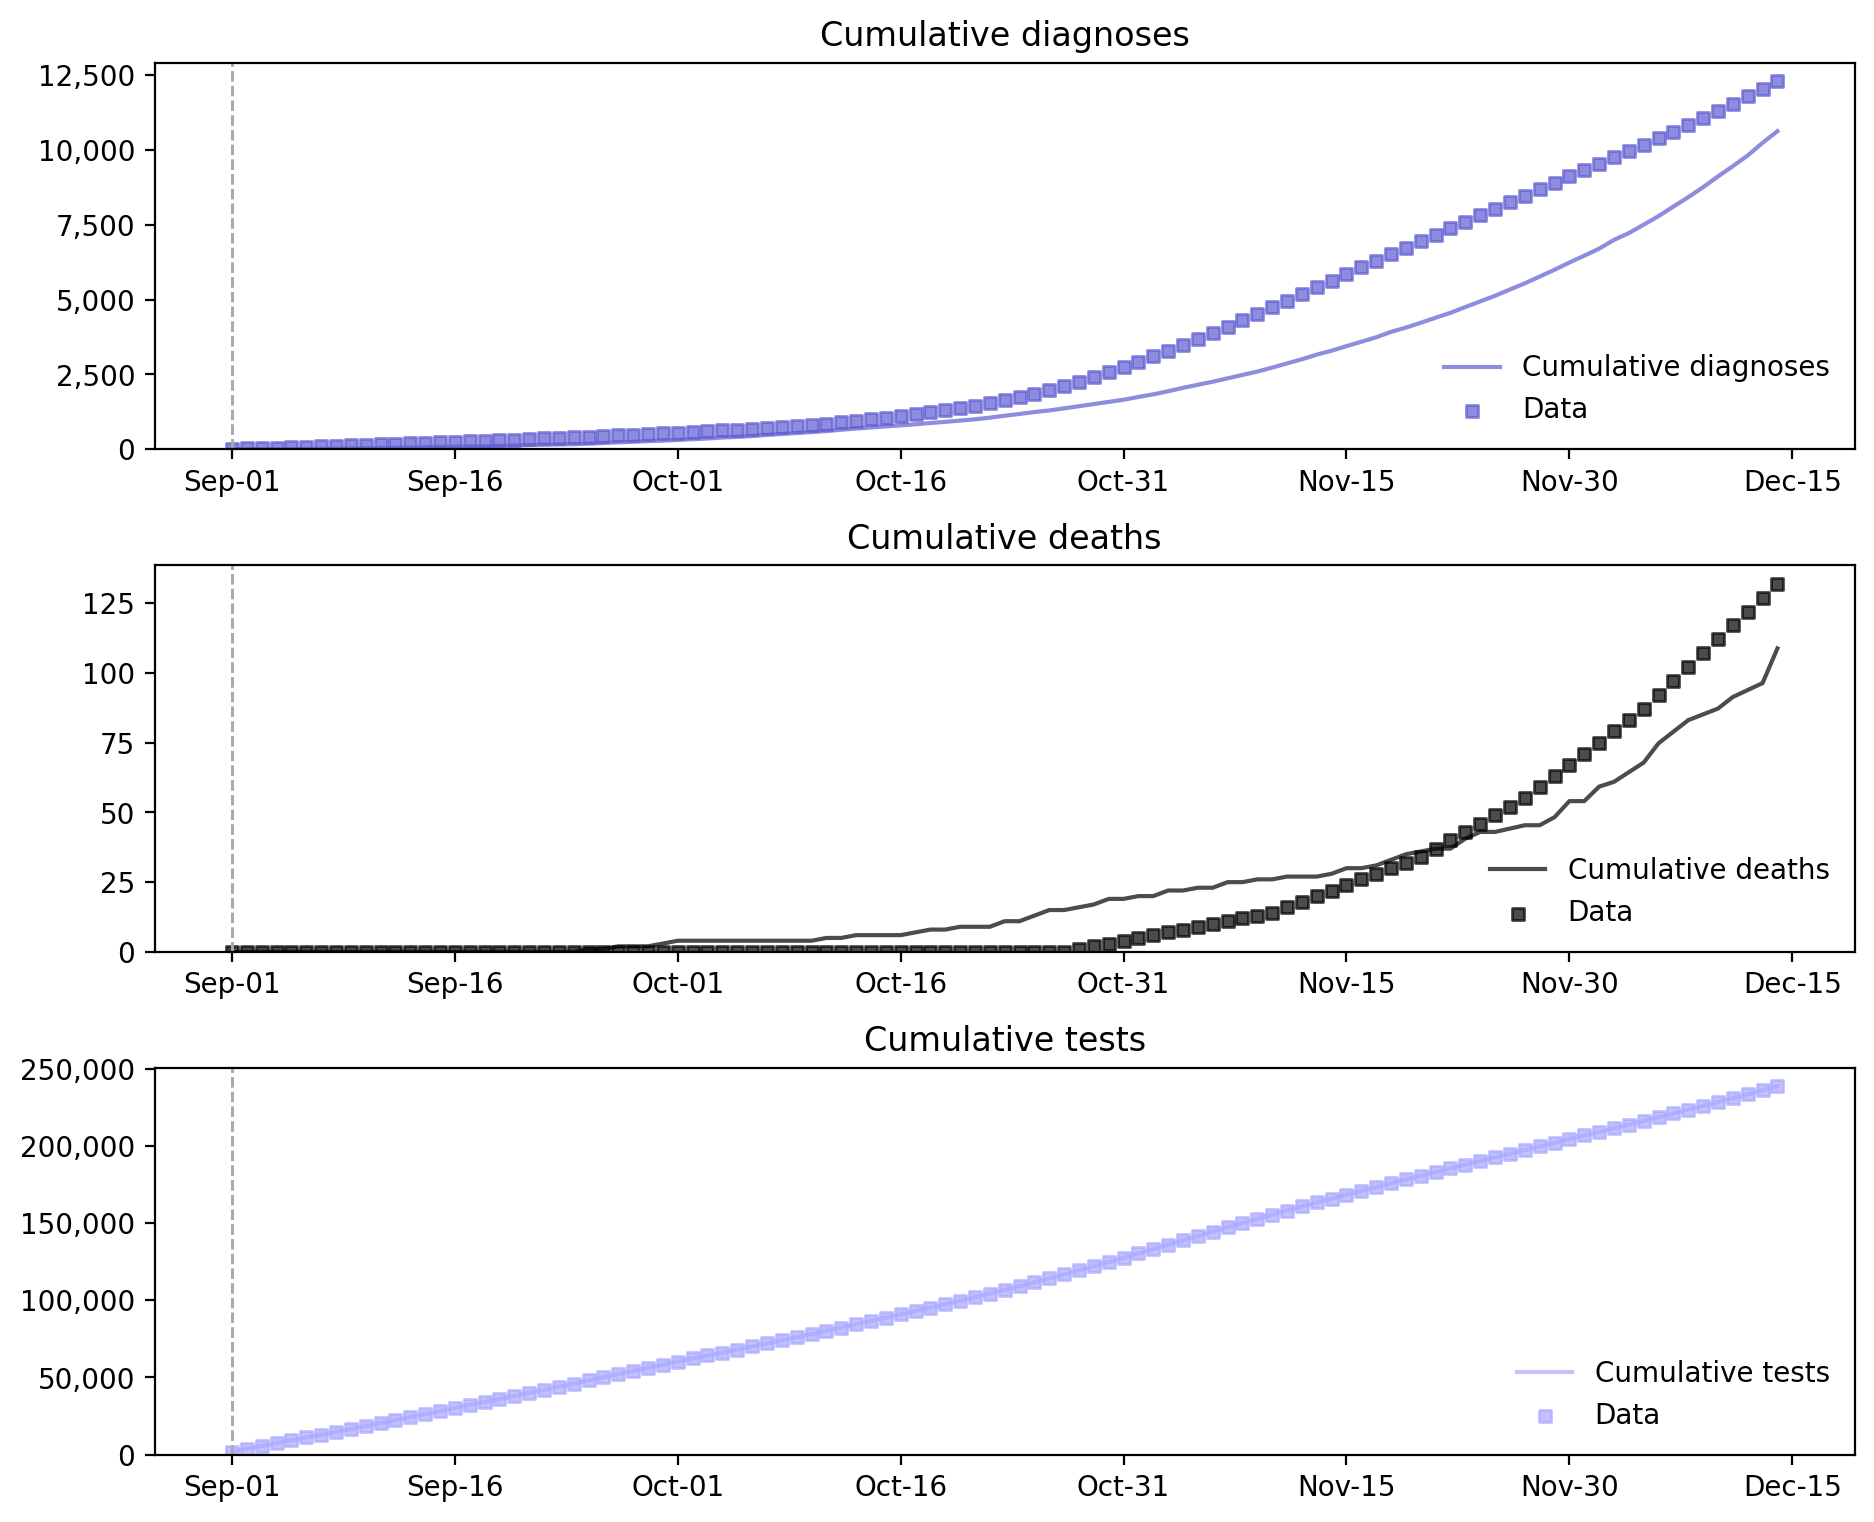

In [5]:
def run_sim_and_plot(pars: dict):
    sim = cv.Sim(pars=pars, datafile=df, interventions=interventions)
    sim.run()
    return sim.plot(to_plot=['cum_diagnoses', 'cum_deaths', 'cum_tests'])


run_sim_and_plot(baseline_pars)

In [6]:
# use mean squared error as goodness of fit
# see https://docs.idmod.org/projects/covasim/en/latest/covasim.misc.html?highlight=compute_gof#covasim.misc.compute_gof
compute_gof_kwargs = {'normalize': False, 'use_squared': True, 'as_scalar': 'mean'}


def objective(x, n_runs=10):
    print(f'Running sim for beta={x[0]}, rel_severe_prob={x[1]}')
    opt_pars = dict(
        beta=x[0],
        rel_severe_prob=x[1],
    )
    pars = {**baseline_pars, **opt_pars}
    sim = cv.Sim(pars=pars, datafile=df, interventions=interventions)
    msim = cv.MultiSim(sim)
    msim.run(n_runs=n_runs)
    mismatches = [sim.compute_fit(**compute_gof_kwargs).mismatch for sim in msim.sims]
    return np.mean(mismatches)

In [7]:
opt_results_nelder = optimize.minimize(objective, x0=guess, method='nelder-mead', options={'disp': True})

Running sim for beta=0.0155, rel_severe_prob=1.1
Running sim for beta=0.016275, rel_severe_prob=1.1
Running sim for beta=0.0155, rel_severe_prob=1.1550000000000002
Running sim for beta=0.016274999999999998, rel_severe_prob=1.045
Running sim for beta=0.016662499999999997, rel_severe_prob=0.9899999999999998
Running sim for beta=0.017437499999999995, rel_severe_prob=0.9899999999999998
Running sim for beta=0.015984375, rel_severe_prob=1.0725
Running sim for beta=0.01637187499999999, rel_severe_prob=0.9624999999999999
Running sim for beta=0.017049999999999992, rel_severe_prob=0.8799999999999997
Running sim for beta=0.01625078125, rel_severe_prob=1.024375
Running sim for beta=0.016541406250000005, rel_severe_prob=1.051875
Running sim for beta=0.016414257812499992, rel_severe_prob=0.9848437499999999
Running sim for beta=0.016456640624999998, rel_severe_prob=1.0071875
Running sim for beta=0.016311328124999996, rel_severe_prob=0.9934375
Running sim for beta=0.01639609375, rel_severe_prob=1.0381

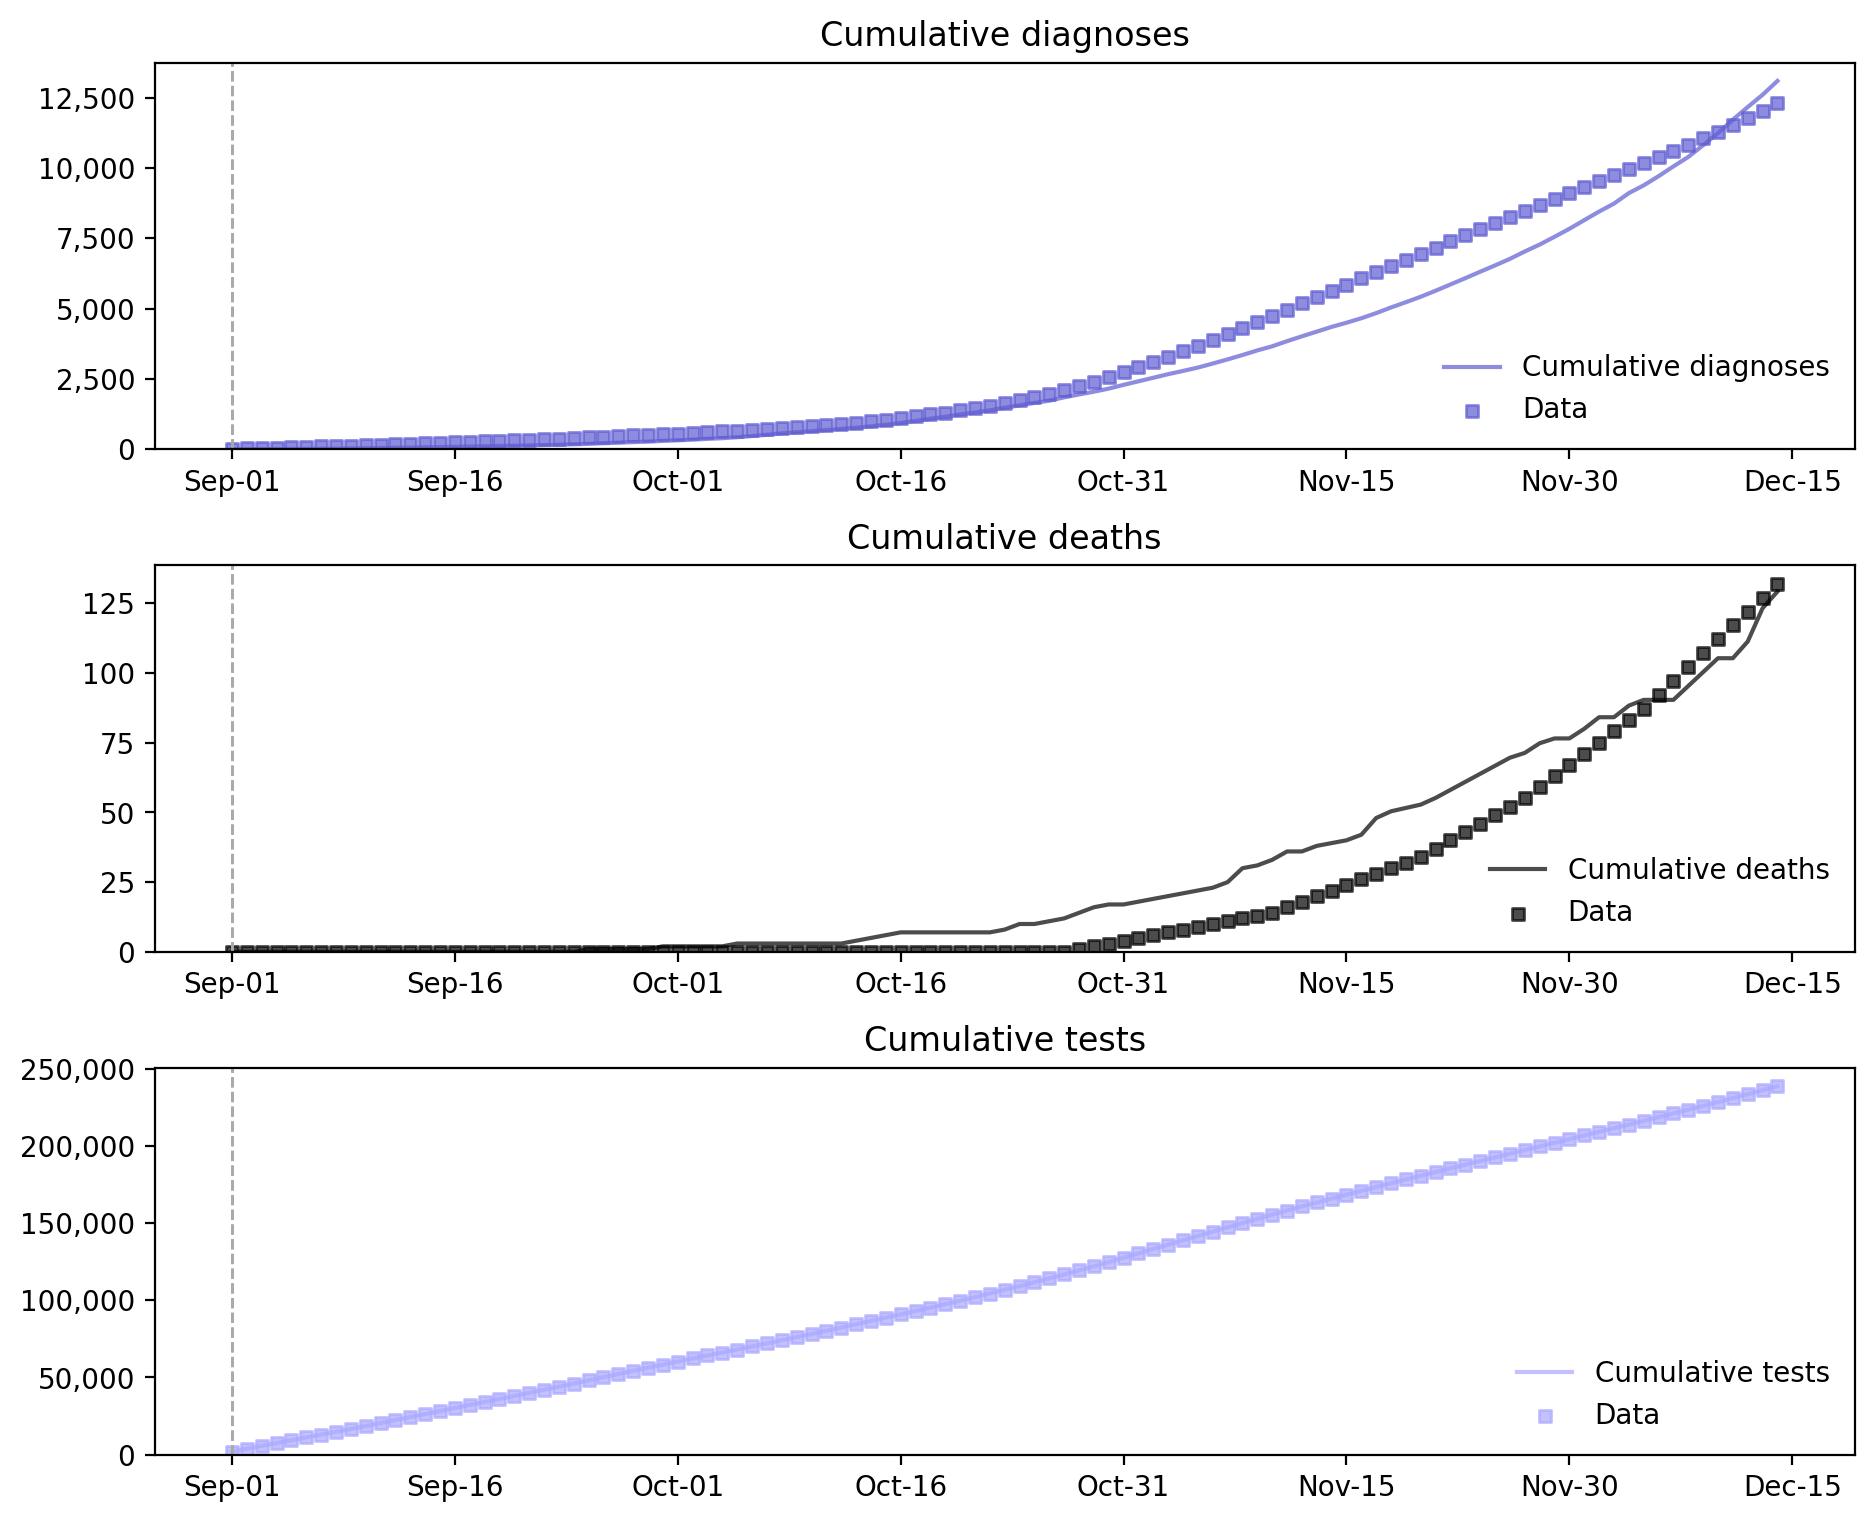

In [8]:
opt_pars_nelder = dict(
    beta=opt_results_nelder.x[0],
    rel_severe_prob=opt_results_nelder.x[1],
)
run_sim_and_plot({**baseline_pars, **opt_pars_nelder})

In [9]:
opt_results_powell = optimize.minimize(objective, x0=guess, method='Powell', options={'disp': True})
# interrupted after 215 iterations because it seems to cycle...

Running sim for beta=0.0155, rel_severe_prob=1.1
Running sim for beta=0.0155, rel_severe_prob=1.1
Running sim for beta=1.0155, rel_severe_prob=1.1
Running sim for beta=-1.602534, rel_severe_prob=1.1
Running sim for beta=0.0155, rel_severe_prob=1.1
Running sim for beta=-0.6025339748440001, rel_severe_prob=1.1
Running sim for beta=0.39746600000000004, rel_severe_prob=1.1
Running sim for beta=-0.2928479919568678, rel_severe_prob=1.1
Running sim for beta=0.16139802515600005, rel_severe_prob=1.1
Running sim for beta=-0.10227844909579697, rel_severe_prob=1.1
Running sim for beta=0.07122808507673671, rel_severe_prob=1.1
Running sim for beta=-0.02948736308732519, rel_severe_prob=1.1
Running sim for beta=0.03678623374442082, rel_severe_prob=1.1
Running sim for beta=-0.001683643129013257, rel_severe_prob=1.1
Running sim for beta=0.02363061755842144, rel_severe_prob=1.1
Running sim for beta=0.008936432568583322, rel_severe_prob=1.1
Running sim for beta=0.018605619466320004, rel_severe_prob=1.1
Ru

Process ForkPoolWorker-1231:
Process ForkPoolWorker-1230:
Process ForkPoolWorker-1232:
Process ForkPoolWorker-1229:
Traceback (most recent call last):
  File "/home/tom/.local/share/virtualenvs/data_driven-S9i1bRE7/lib/python3.9/site-packages/multiprocess/process.py", line 315, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/tom/.local/share/virtualenvs/data_driven-S9i1bRE7/lib/python3.9/site-packages/multiprocess/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/home/tom/.local/share/virtualenvs/data_driven-S9i1bRE7/lib/python3.9/site-packages/multiprocess/process.py", line 315, in _bootstrap
    self.run()
  File "/home/tom/.local/share/virtualenvs/data_driven-S9i1bRE7/lib/python3.9/site-packages/multiprocess/pool.py", line 114, in worker
    task = get()
  File "/home/tom/.local/share/virtualenvs/data_driven-S9i1bRE7/lib/python3.9/site-packages/multi

KeyboardInterrupt: 

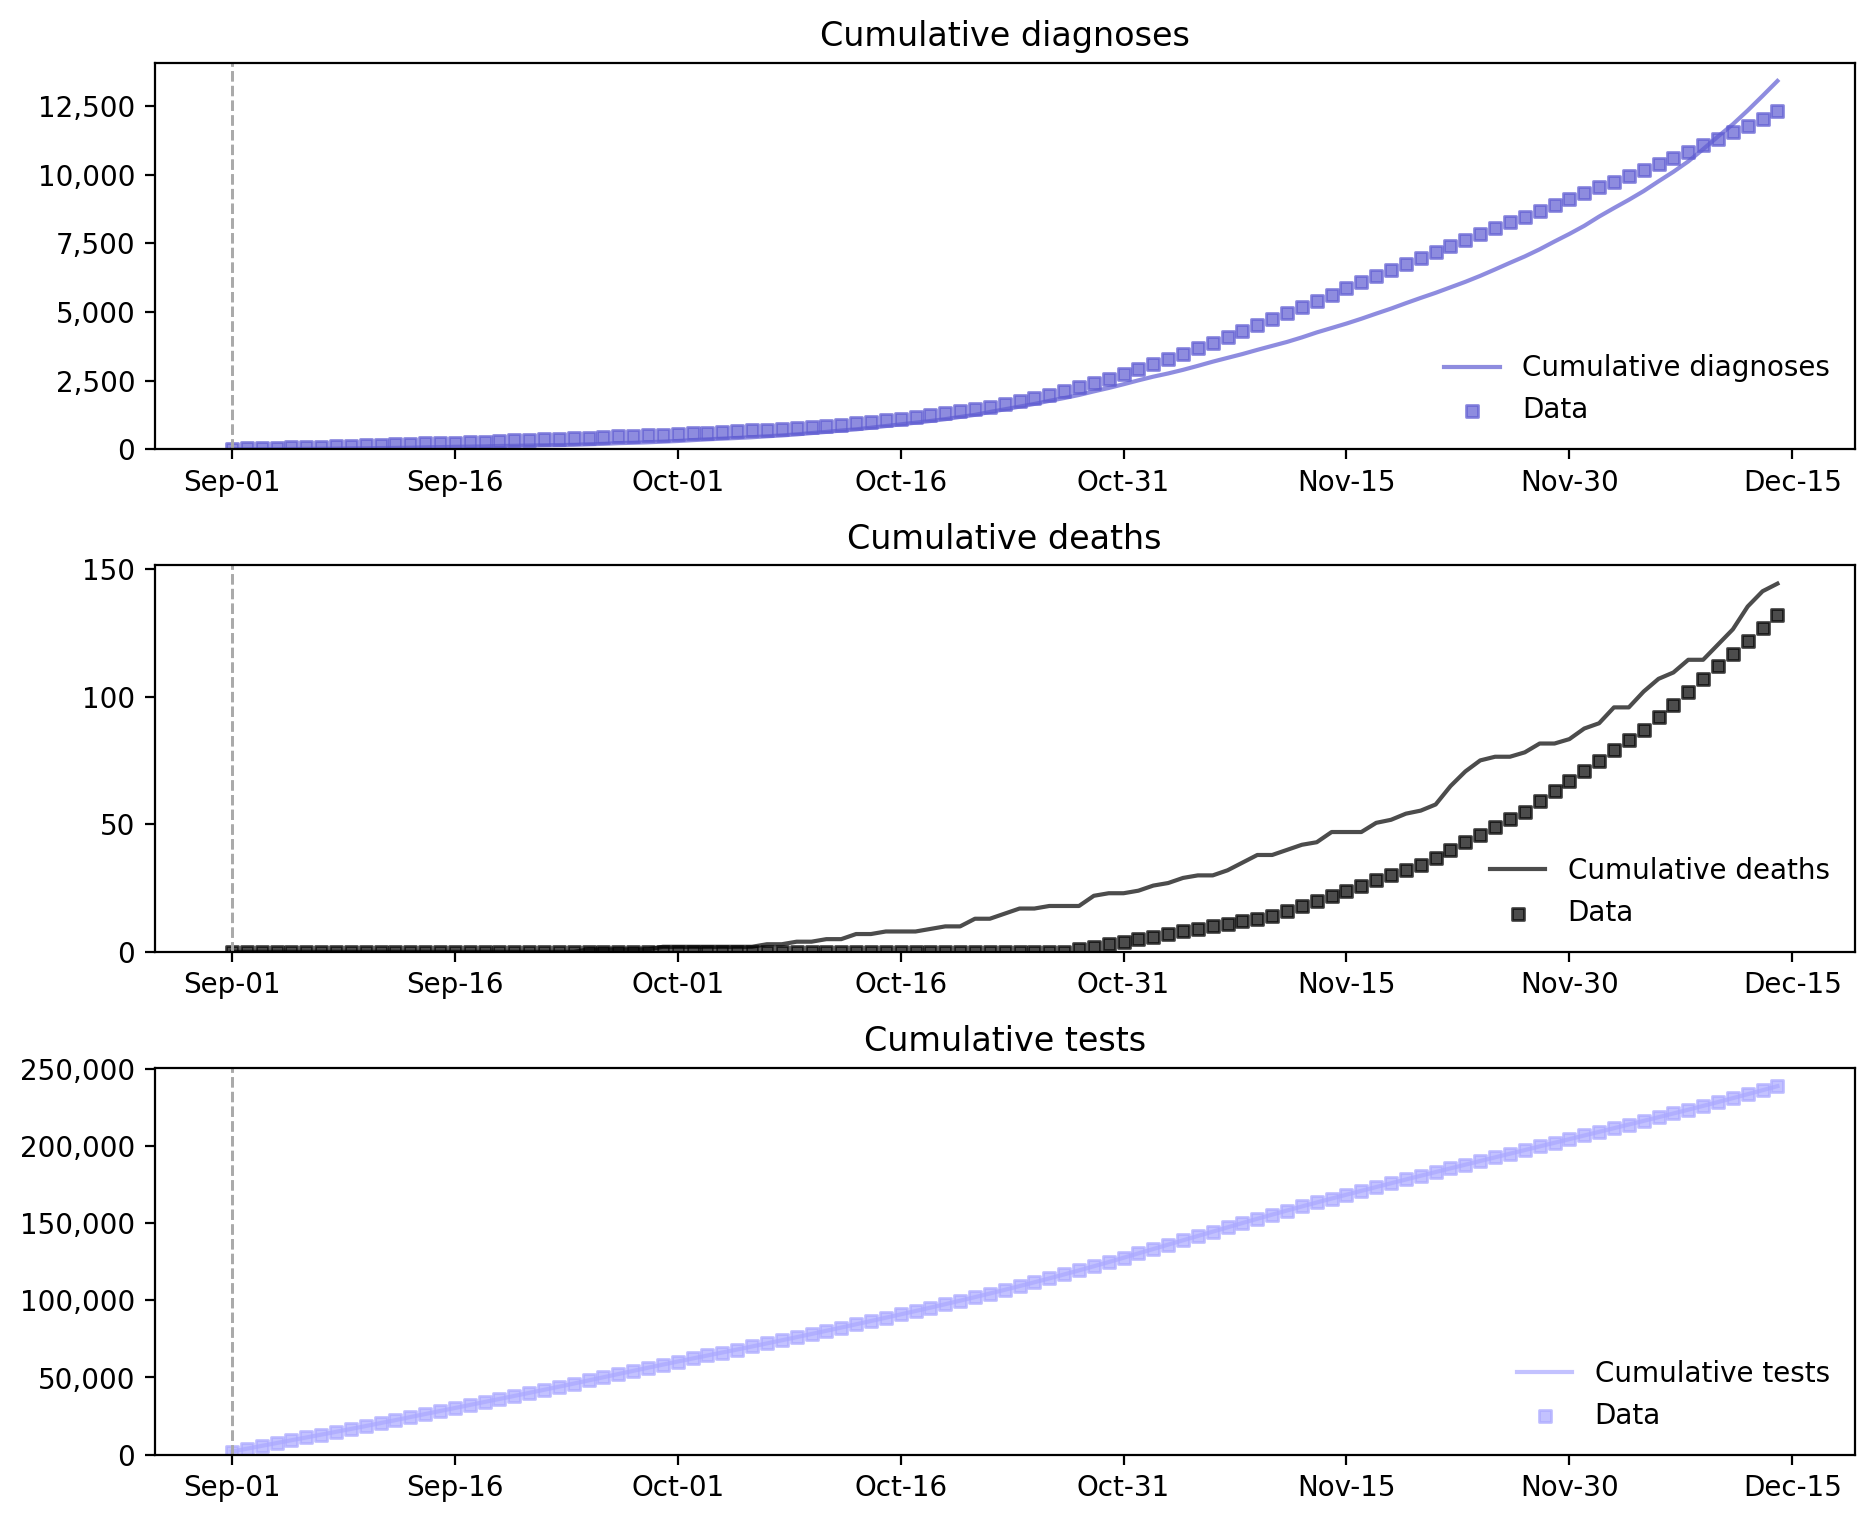

In [10]:
# insert values from stdout
opt_pars_powell = dict(
    beta=0.016151241873871763,
    rel_severe_prob=1.0744559560710147
)
run_sim_and_plot({**baseline_pars, **opt_pars_powell})